In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data

import random, os, pathlib, time
from tqdm import tqdm
from sklearn import datasets

In [ ]:
# device = torch.device("cuda:0")
device = torch.device("cpu")

In [ ]:
from sklearn import tree

## 2D regression dataset

In [14]:
num_points = 100
# X1 = np.linspace(-2.5, 1.9, num_points)
X1 = np.linspace(-2.5, 2.5, num_points)
X2 = np.linspace(-2.5, 3, num_points)
# X2 = np.linspace(-2.2, 2.1, num_points)
X1, X2 = np.meshgrid(X1, X2)

Y = np.sin(np.sqrt(X1**2 + X2**2))*2-1. - 0.1*(X1)+0.02*(X2)
# Y = np.sqrt(X1**2 + X2**2)

####Scaling the data to range -1,1
X1 = 2*(X1 - X1.min())/(X1.max() - X1.min()) -1
X2 = 2*(X2 - X2.min())/(X2.max() - X2.min()) -1
Y = 2*(Y - Y.min())/(Y.max() - Y.min()) -1

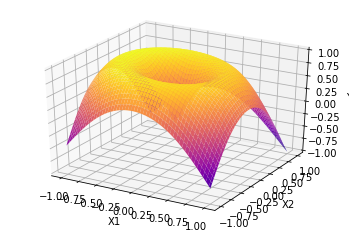

In [15]:
x1 = X1.reshape(-1)
x2 = X2.reshape(-1)
y = Y.reshape(-1)

xx = torch.Tensor(np.c_[x1, x2])
yy = torch.Tensor(Y.reshape(-1,1))

%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X1, X2, Y, cmap='plasma')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.show()

In [16]:
class DistanceTransform(nn.Module):
    
    def __init__(self, input_dim, num_centers, p=2):
        super().__init__()
        self.input_dim = input_dim
        self.num_centers = num_centers
        self.p = p
        
        self.centers = torch.randn(num_centers, input_dim)/3.
#         self.centers = torch.rand(num_centers, input_dim)
        self.centers = nn.Parameter(self.centers)
        self.inv_params = None
    
    def forward(self, x):
        dists = torch.cdist(x, self.centers, p=self.p)
        
        ### normalize similar to UMAP
#         dists = dists-dists.min(dim=1, keepdim=True)[0]
#         dists = dists-dists.mean(dim=1, keepdim=True)
#         dists = dists/dists.std(dim=1, keepdim=True)

        return dists
    
    def set_centroid_to_data_randomly(self, data_loader):
        indices = np.random.permutation(len(data_loader.dataset.data))[:self.centers.shape[0]]
        self.centers.data = data_loader.dataset.data[indices].to(self.centers.device)
        self.centers.data += torch.randn_like(self.centers)*0.01
        pass
    
    def set_centroid_to_data_maxdist(self, data_loader):
        ## sample N points
        N = self.centers.shape[0]
        new_center = torch.empty_like(self.centers)
        min_dists = torch.empty(N)
        count = 0
        for i, (xx, _) in enumerate(tqdm(data_loader)):
            if count < N:
                if N-count < batch_size:
                    #### final fillup
                    new_center[count:count+N-count] = xx[:N-count]
                    xx = xx[N-count:]
                    dists = torch.cdist(new_center, new_center)+torch.eye(N)*1e5
                    min_dists = dists.min(dim=0)[0]
                    count = N

                else:#### fill the center
                    new_center[count:count+len(xx)] = xx
                    count += len(xx)
                    continue

            ammd = min_dists.argmin()
            for i, x in enumerate(xx):
                dists = torch.norm(new_center-x, dim=1)
                md = dists.min()
                if md > min_dists[ammd]:
                    min_dists[ammd] = md
                    new_center[ammd] = x
                    ammd = min_dists.argmin()
        self.centers.data = new_center.to(self.centers.device)
        pass
        
    
    def set_centroid_to_data(self, data_loader):
        new_center = self.centers.data.clone()
        min_dists = torch.ones(self.centers.shape[0])*1e9

        for xx, _ in data_loader:

            dists = torch.cdist(xx, self.centers.data)
            ### min dist of each center to the data points
            min_d, arg_md = dists.min(dim=0)

            ### dont allow same point to be assigned as closest to multiple centroid
            occupied = []
            for i in np.random.permutation(len(arg_md)):
        #     for i, ind in enumerate(arg_md):
                ind = arg_md[i]
                if ind in occupied:
                    min_d[i] = min_dists[i]
                    arg_md[i] = -1
                else:
                    occupied.append(ind)

            ### the index of centroids that have new min_dist
            idx = torch.nonzero(min_d<min_dists).reshape(-1)

            ### assign new_center to the nearest data point
            new_center[idx] = xx[arg_md[idx]]
            min_dists[idx] = min_d[idx]
            
        self.centers.data = new_center.to(self.centers.device)
        pass
    
    def compute_inverse_matrix(self):
#         A = 2*(self.centers.data[1:]-self.centers.data[:-1])
        A = 2*(self.centers[1:]-self.centers[:-1])
        
#         c2 = self.centers.data**2
        c2 = self.centers**2
        Z = (c2[:-1]-c2[1:]).sum(dim=1, keepdim=True)
        
        invA = torch.pinverse(A)
#         invA = A.t()
        self.inv_params = (invA, Z)
        
    def inverse(self, dists):
        assert self.inv_params is not None
        
        d2 = dists**2
        D = d2[:, :-1]-d2[:, 1:]

        invA, Z = self.inv_params
        xrec = torch.matmul(invA, D.t()-Z).t()
        return xrec

In [17]:
class EMA(object):

    def __init__(self, momentum=0.1, mu=None):
        self.mu = mu
        self.momentum = momentum

    def __call__(self, x):
        if self.mu is None:
            self.mu = x
        self.mu = self.momentum*self.mu + (1.0 - self.momentum)*x
        return self.mu

## Ordinary Decision Tree

In [5]:
dtr = tree.DecisionTreeRegressor(max_depth=4)

In [6]:
dtr.fit(xx.data.numpy(), yy.data.numpy())
yout = dtr.predict(xx.data.numpy())

%matplotlib tk
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(X1, X2, Y)
ax.scatter(X1, X2, yout.reshape(-1), color='r', marker='.')
plt.pause(1)
plt.show()

NameError: name 'xx' is not defined

In [60]:
mse = ((yout-yy.data.numpy())**2).mean()
print(mse)

0.24598739378695808


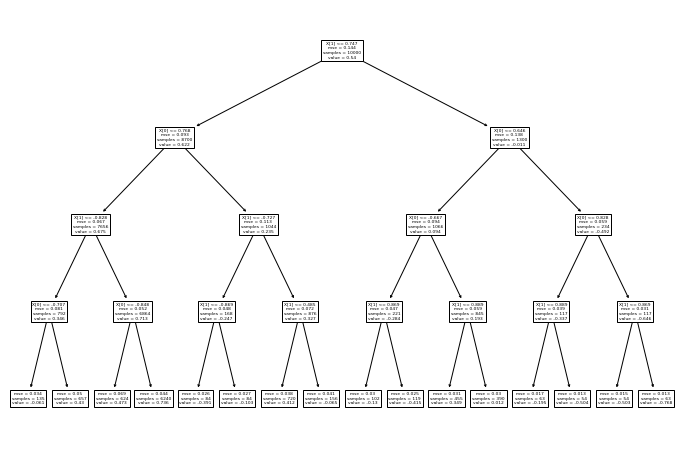

In [62]:
%matplotlib inline
plt.figure(figsize=(12,8))
tree.plot_tree(dtr)
plt.savefig("./models/tree_2d_reg_ord.svg")

### Tree with Distance Transform

In [73]:
dt = DistanceTransform(2, num_centers=3)
# dt.centers.data += torch.randn_like(dt.centers)*0.01
dt.centers.data = xx[np.random.permutation(len(xx))[:dt.num_centers]]


tensor([[-0.2525, -0.5152],
        [ 0.9596,  0.4747],
        [-0.8788,  0.7778]])


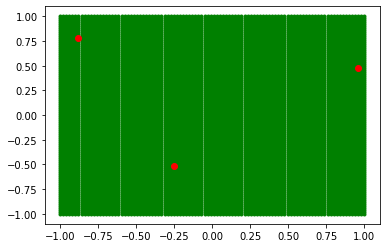

In [74]:
%matplotlib inline
fig = plt.figure()
plt.scatter(xx[:,0], xx[:,1], c='g', marker='.')
plt.scatter(dt.centers.data[:,0], dt.centers.data[:,1], c='r', marker='o')
print(dt.centers.data)

In [75]:
xx_ = dt(xx).data
xx_

tensor([[0.8910, 2.4525, 1.7819],
        [0.8741, 2.4364, 1.7806],
        [0.8573, 2.4204, 1.7796],
        ...,
        [1.9403, 0.5253, 1.8518],
        [1.9530, 0.5256, 1.8718],
        [1.9658, 0.5268, 1.8919]])

In [76]:
dtr_ = tree.DecisionTreeRegressor(max_depth=4)

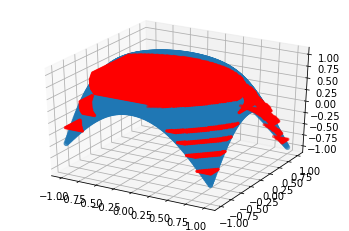

In [77]:
dtr_.fit(xx_.data.numpy(), yy.data.numpy())
yout_ = dtr_.predict(xx_.data.numpy())

%matplotlib tk
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(X1, X2, Y)
ax.scatter(X1, X2, yout_.reshape(-1), color='r', marker='.')
plt.pause(0.1)
plt.show()

In [78]:
mse = ((yout_-yy.data.numpy())**2).mean()
print(mse)

0.2551496235610955


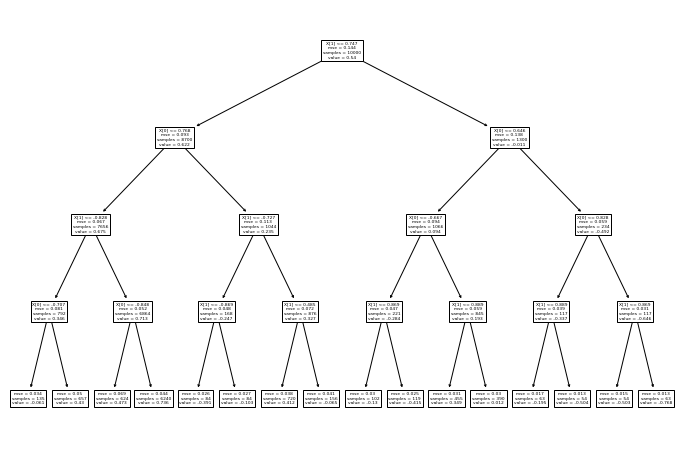

In [79]:
%matplotlib inline
plt.figure(figsize=(12,8))
tree.plot_tree(dtr)
plt.savefig("./models/tree_2d_reg_dist.svg")

# Classification Dataset 2D

In [27]:
def twospirals(n_points, noise=.5 , ang=720):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * ang * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_points),np.ones(n_points))))

np.random.seed(987)
# x, y = twospirals(200, ang=420)
# x, y = twospirals(200, ang=400)
x, y = datasets.make_blobs(n_samples=200, centers=3, cluster_std=0.60, random_state=0)
x, Y = x/10, y.reshape(-1)
X1, X2 = x[:,0], x[:,1]

####Scaling the data to range -1,1
X1 = 2*(X1 - X1.min())/(X1.max() - X1.min()) -1
X2 = 2*(X2 - X2.min())/(X2.max() - X2.min()) -1

x1 = X1.reshape(-1)
x2 = X2.reshape(-1)

xx = torch.Tensor(np.c_[x1, x2])
yy = torch.Tensor(Y.reshape(-1,1))

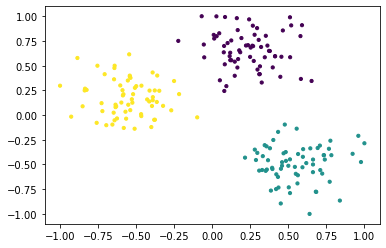

In [28]:
%matplotlib inline
fig = plt.figure()
plt.scatter(X1, X2, c=Y, s=10)
plt.show()

In [29]:
num_points = 50
_X1 = np.linspace(-2.5, 2.5, num_points)
_X2 = np.linspace(-2.5, 3, num_points)
_X1, _X2 = np.meshgrid(X1, X2)
xgrid = np.c_[_X1.reshape(-1,1), _X2.reshape(-1,1)]

In [30]:
xgrid.shape

(40000, 2)

## Ordinary Decision Tree

In [43]:
dtr = tree.DecisionTreeClassifier(max_depth=2)

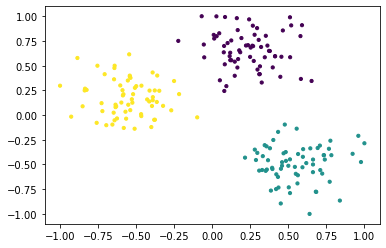

In [44]:
dtr.fit(xx.data.numpy(), yy.data.numpy())
yout = dtr.predict(xx.data.numpy())

%matplotlib inline
plt.scatter(X1, X2, c=yout, s=10)
plt.show()

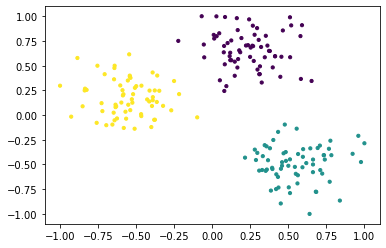

In [45]:
%matplotlib inline

plt.scatter(X1, X2, c=yout, s=10)
plt.show()

In [46]:
yout.shape

(200,)

In [40]:
acc = yout.reshape(-1,1)==yy.data.numpy()
acc = np.count_nonzero(acc)/len(acc)
print(acc)

1.0


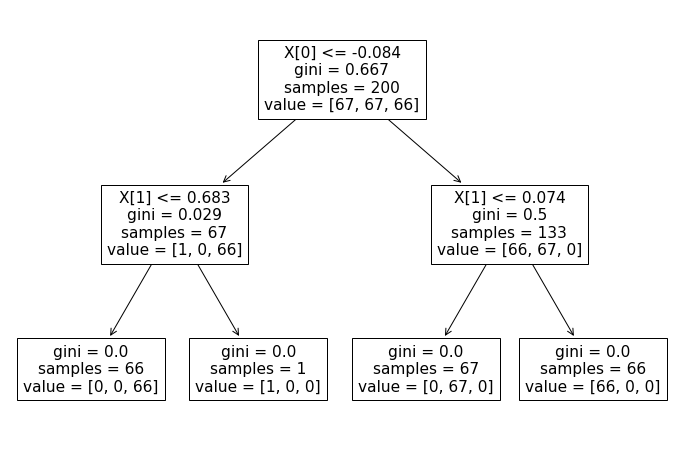

In [35]:
%matplotlib inline
plt.figure(figsize=(12,8))
tree.plot_tree(dtr)
plt.savefig("./models/tree_2d_cls_ord.svg")

### Decision tree with distance transform

In [36]:
dt = DistanceTransform(2, num_centers=3)
# dt.centers.data += torch.randn_like(dt.centers)*0.01
dt.centers.data = xx[np.random.permutation(len(xx))[:dt.num_centers]]

NameError: name 'DistanceTransform' is not defined

tensor([[-0.9180,  0.0757],
        [ 0.0847,  0.8992],
        [ 0.2251,  0.3768]])


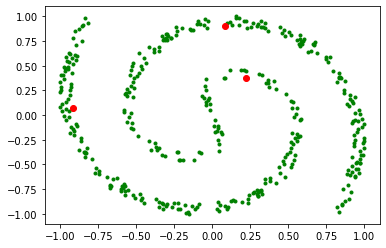

In [146]:
%matplotlib inline
fig = plt.figure()
plt.scatter(xx[:,0], xx[:,1], c='g', marker='.')
plt.scatter(dt.centers.data[:,0], dt.centers.data[:,1], c='r', marker='o')
print(dt.centers.data)

In [147]:
xx_ = dt(xx).data
xx_

tensor([[1.5086, 1.7996, 1.2707],
        [1.5156, 1.7353, 1.2016],
        [0.2945, 1.1862, 1.1994],
        ...,
        [0.4475, 0.8688, 0.7479],
        [1.8459, 1.2758, 0.8246],
        [0.9564, 1.2881, 0.8134]])

In [148]:
xx_.shape, yy.shape

(torch.Size([400, 3]), torch.Size([400, 1]))

In [149]:
dtr_ = tree.DecisionTreeClassifier(max_depth=4)

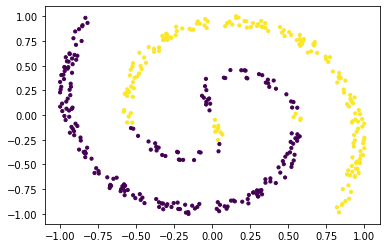

In [150]:
dtr_.fit(xx_.data.numpy(), yy.data.numpy())
yout_ = dtr_.predict(xx_.data.numpy())#.reshape(-1,1)

%matplotlib inline
plt.scatter(X1, X2, c=yout_, s=10)
plt.show()

In [151]:
yout_.shape

(400,)

In [152]:
acc = yout_.reshape(-1,1)==yy.data.numpy()
acc = np.count_nonzero(acc)/len(acc)
print(acc)

0.9375


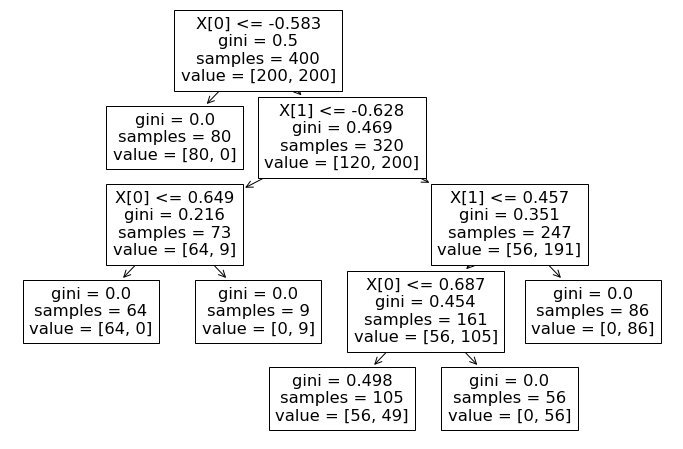

In [153]:
%matplotlib inline
plt.figure(figsize=(12,8))
tree.plot_tree(dtr)
plt.savefig("./models/tree_2d_cls_dist.svg")